This notebook does the following:
1. Load raw reddit submission data from dataframes scraped by `scripts/get_reddit_gamethreads.py`.
2. Add a couple of useful columns: `date` for the date that the game was played, and `is_postgame` indicating
whether the post is an in-game thread or post-game thread
3. Parse the title to extract the names of the two teams playing, in the form of team_ids as given in `data/teams.csv`.
4. Add a `gid` column, of the form `YYYY-mm-dd_team1ID_team2ID`, where `(team1ID,team2ID)` are the team_ids of the
two teams sorted in alphabetical order. This uniquely identifies each game.

In [1]:
import glob
import datetime as dt
import re
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import watchcbb.reddit_utils as ru

### Load gamethread dataframes from gzipped pickled files

In [2]:
dfs = []
for fname in glob.glob('../data/gamethreads/*/*.pkl.gz'):
    with open(fname, 'rb') as fid:
        df = pd.read_pickle(fid, compression='gzip')
    dfs.append(df)
df = pd.concat(dfs)
df = df[df.title.apply(lambda x: '[game' in x.lower() or '[post' in x.lower())].reset_index()
print(df.shape)
df.head()

(19766, 116)


,index,_reddit,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,...,_fetched,comment_limit,comment_sort,_comments_by_id,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,top_awarded_type
0,0,<praw.reddit.Reddit object at 0x7f6dfa9b9ed0>,None,CollegeBasketball,[removed],t2_1j9zdlp,False,None,0,False,...,False,2048,confidence,{},NaN,NaN,NaN,NaN,NaN,NaN
1,1,<praw.reddit.Reddit object at 0x7f6dfa9b9ed0>,None,CollegeBasketball,[Box score](https://www.espn.com/mens-college-...,t2_eh5w6,False,None,0,False,...,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN
2,2,<praw.reddit.Reddit object at 0x7f6dfa9b9ed0>,None,CollegeBasketball,[Box Score](https://www.espn.com/mens-college-...,t2_1j9zdlp,False,None,0,False,...,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN
3,3,<praw.reddit.Reddit object at 0x7f6dfa9b9ed0>,None,CollegeBasketball,[Box Score](https://www.espn.com/mens-college-...,t2_1j9zdlp,False,None,0,False,...,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN
4,4,<praw.reddit.Reddit object at 0x7f6dfa9b9ed0>,None,CollegeBasketball,[Box Score](https://www.espn.com/mens-college-...,t2_1j9zdlp,False,None,0,False,...,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN


### Add `timestamp`, `date`, and `is_postgame` columns

In [3]:
df["timestamp"] = df.created.apply(dt.datetime.fromtimestamp)  # UNIX epoch -> datetime (in UTC)
df["date"] = df.created.apply(ru.date_from_timestamp)  # Convert to date of game
df["is_postgame"] = df.title.apply(lambda x:"[post " in x.lower())  # in-game or post-game thread?
df = df.sort_values("timestamp").reset_index()
df[["timestamp","date","id","title","is_postgame","ups","num_comments"]].head(30)

,timestamp,date,id,title,is_postgame,ups,num_comments
0,2017-11-10 16:30:24,2017-11-10,7c1ens,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,67,84
1,2017-11-10 16:31:23,2017-11-10,7c1evc,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
2,2017-11-10 16:32:22,2017-11-10,7c1f3p,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
3,2017-11-10 16:33:21,2017-11-10,7c1fc2,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
4,2017-11-10 16:34:19,2017-11-10,7c1fiq,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
5,2017-11-10 16:35:20,2017-11-10,7c1fq9,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
6,2017-11-10 16:36:19,2017-11-10,7c1fxe,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
7,2017-11-10 16:37:16,2017-11-10,7c1g4i,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
8,2017-11-10 16:38:15,2017-11-10,7c1gat,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0
9,2017-11-10 16:39:13,2017-11-10,7c1ghu,[Game Thread] Spring Arbor @ Eastern Michigan ...,False,1,0


### Parse the titles into 2-tuples of team names

In [4]:
print((df.title.apply(ru.parse_title).isna()).sum())
df.title.apply(ru.parse_title).head(20)

366


0     [spring-arbor, eastern-michigan]
1     [spring-arbor, eastern-michigan]
2     [spring-arbor, eastern-michigan]
3     [spring-arbor, eastern-michigan]
4     [spring-arbor, eastern-michigan]
5     [spring-arbor, eastern-michigan]
6     [spring-arbor, eastern-michigan]
7     [spring-arbor, eastern-michigan]
8     [spring-arbor, eastern-michigan]
9     [spring-arbor, eastern-michigan]
10    [spring-arbor, eastern-michigan]
11    [spring-arbor, eastern-michigan]
12    [spring-arbor, eastern-michigan]
13    [spring-arbor, eastern-michigan]
14    [spring-arbor, eastern-michigan]
15    [spring-arbor, eastern-michigan]
16    [spring-arbor, eastern-michigan]
17    [spring-arbor, eastern-michigan]
18    [spring-arbor, eastern-michigan]
19    [spring-arbor, eastern-michigan]
Name: title, dtype: object

### Convert team names generated in above cell to team_ids
* These should match those stored in `data/teams.csv`.
* Replacements are made to fix some common errors
* A value of `None` is stored when we can't guess the corred ID
* The list outputted below shows the most common names that weren't able to be parsed

In [24]:
import importlib
ru = importlib.reload(ru)

ru._BAD = []

df["team_ids"] = df.title.apply(ru.parse_title).apply(ru.fix_names)
print(df.team_ids.isna().sum())
pd.Series(ru._BAD).value_counts().head(20)

1477


spring-arbor              23
chaminade                 11
colorado-mines            10
                           9
toccoa-falls               9
saint-bonaventure          8
mount-saint-marys          8
ar-little-rock             7
st.-francis-brooklyn       7
st.-joes                   7
uni                        7
grambling-state            7
portland-st                6
middle-tennessee-state     6
san-diego-christian        6
mtsu                       6
multnomah                  6
test                       5
ut-rio-grande              5
md-eastern-shore           5
dtype: int64

### Now generate a unique `gid` for each game
Format is `YYYY-mm-dd_teamID1_teamID2`, where `(teamID1,teamID2)` are sorted in alphabetical order

In [25]:
def get_gid(row):
    if row.team_ids is None:
        return None
    ids = sorted(row.team_ids)
    return f'{row.date}_{ids[0]}_{ids[1]}'

df["gid"] = df.apply(get_gid, axis=1)
tosave = df[["date","timestamp","id","gid","is_postgame","ups","num_comments","title"]].copy()
tosave.head(10)

,date,timestamp,id,gid,is_postgame,ups,num_comments,title
0,2017-11-10,2017-11-10 16:30:24,7c1ens,None,False,67,84,[Game Thread] Spring Arbor @ Eastern Michigan ...
1,2017-11-10,2017-11-10 16:31:23,7c1evc,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
2,2017-11-10,2017-11-10 16:32:22,7c1f3p,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
3,2017-11-10,2017-11-10 16:33:21,7c1fc2,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
4,2017-11-10,2017-11-10 16:34:19,7c1fiq,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
5,2017-11-10,2017-11-10 16:35:20,7c1fq9,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
6,2017-11-10,2017-11-10 16:36:19,7c1fxe,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
7,2017-11-10,2017-11-10 16:37:16,7c1g4i,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
8,2017-11-10,2017-11-10 16:38:15,7c1gat,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...
9,2017-11-10,2017-11-10 16:39:13,7c1ghu,None,False,1,0,[Game Thread] Spring Arbor @ Eastern Michigan ...


### Some `gid`s are duplicated due to multiple/deleted posts. These are the ones with highest multiplicity.

In [26]:
tosave.gid.value_counts().head(10)

2018-02-17_kansas_west-virginia                13
2019-12-07_arkansas-little-rock_north-texas    12
2018-01-17_alabama_auburn                      11
2018-11-24_louisiana-state_texas-am            10
2018-02-15_purdue_wisconsin                    10
2019-11-10_florida_florida-state                9
2020-02-19_indiana_minnesota                    9
2018-12-08_marquette_wisconsin                  9
2018-01-27_duke_virginia                        8
2017-11-24_florida_gonzaga                      8
Name: gid, dtype: int64

### We want to save only the one example of game/post-game thread with highest comment count
* First sort by `gid` and `is_postgame` to group into groups that we want to reduce
* Sort by `num_comments` and `ups`, and we will then keep only the last example of each group

In [27]:
tosave = tosave.sort_values(['gid','is_postgame','num_comments','ups'])
tosave[tosave.gid=='2019-11-10_florida_florida-state']

,date,timestamp,id,gid,is_postgame,ups,num_comments,title
13845,2019-11-10,2019-11-10 19:58:25,duer62,2019-11-10_florida_florida-state,False,1,0,[Game Thread] Florida State @ #6 Florida (1:00...
13844,2019-11-10,2019-11-10 19:58:23,duer5r,2019-11-10_florida_florida-state,False,38,312,[Game Thread] Florida State @ #6 Florida (1:00...
13859,2019-11-10,2019-11-10 22:14:42,dugox6,2019-11-10_florida_florida-state,True,1,0,[Post Game Thread] Florida State defeats #6 Fl...
13856,2019-11-10,2019-11-10 22:14:00,dugohg,2019-11-10_florida_florida-state,True,2,0,[Post Game Thread] Florida State defeats #6 Fl...
13861,2019-11-10,2019-11-10 22:30:44,dugx5q,2019-11-10_florida_florida-state,True,0,1,[Post Game Thread] Florida State defeats Flori...
13860,2019-11-10,2019-11-10 22:29:36,dugwlz,2019-11-10_florida_florida-state,True,1,1,[Post Game Thread] Florida State defeats Flori...
13857,2019-11-10,2019-11-10 22:14:04,dugoih,2019-11-10_florida_florida-state,True,1,2,[Post Game Thread] Florida State defeats #6 Fl...
13862,2019-11-10,2019-11-10 22:33:07,dugyd8,2019-11-10_florida_florida-state,True,2,2,[Post Game Thread] Florida State defeats #6 Fl...
13855,2019-11-10,2019-11-10 22:13:57,dugogq,2019-11-10_florida_florida-state,True,1011,240,[Post Game Thread] Florida State defeats #6 Fl...


### Now drop the unwanted duplicates (as well as `None` gid values)

In [28]:
print("Before drop duplicates", tosave.shape)
tosave = tosave.drop_duplicates(['gid','is_postgame'], keep='last')
print("Before dropna", tosave.shape)
tosave.dropna(axis=0, subset=['gid'],inplace=True)
print("After dropna", tosave.shape)
tosave[tosave.gid=='2019-11-10_florida_florida-state']

Before drop duplicates (19766, 8)
Before dropna (14389, 8)
After dropna (14387, 8)


,date,timestamp,id,gid,is_postgame,ups,num_comments,title
13844,2019-11-10,2019-11-10 19:58:23,duer5r,2019-11-10_florida_florida-state,False,38,312,[Game Thread] Florida State @ #6 Florida (1:00...
13855,2019-11-10,2019-11-10 22:13:57,dugogq,2019-11-10_florida_florida-state,True,1011,240,[Post Game Thread] Florida State defeats #6 Fl...


### Check that everything looks good, and save the cleaned dataframe to a pickled file

In [29]:
tosave[tosave.gid.apply(lambda x:"_purdue" in x)].head(20)

,date,timestamp,id,gid,is_postgame,ups,num_comments,title
77,2017-11-10,2017-11-11 02:58:05,7c5csb,2017-11-10_purdue_southern-illinois-edwardsville,False,19,45,[Game Thread] SIU-Edwardsville @ #19 Purdue (8...
125,2017-11-10,2017-11-11 05:22:01,7c63kq,2017-11-10_purdue_southern-illinois-edwardsville,True,12,15,[Post Game Thread] Purdue defeats SIU-Edwardsv...
192,2017-11-12,2017-11-12 22:00:31,7chout,2017-11-12_chicago-state_purdue,False,23,57,[Game Thread] Chicago State @ #19 Purdue (4:00...
225,2017-11-12,2017-11-13 01:20:09,7cizew,2017-11-12_chicago-state_purdue,True,231,32,[Post Game Thread] #19 Purdue defeats Chicago ...
330,2017-11-14,2017-11-15 02:30:27,7d07io,2017-11-14_marquette_purdue,False,51,684,[Game Thread] #17 Purdue @ Marquette (8:30 PM ET)
353,2017-11-14,2017-11-15 05:58:08,7d1h23,2017-11-14_marquette_purdue,True,148,73,[Post Game Thread] #19 Purdue defeats Marquett...
574,2017-11-18,2017-11-19 01:00:25,7dwgxh,2017-11-18_fairfield_purdue,False,22,53,[Game Thread] Fairfield @ #17 Purdue (7:00 PM ET)
606,2017-11-19,2017-11-19 16:53:10,7e10js,2017-11-19_fairfield_purdue,True,98,31,[Post Game Thread] #19 Purdue defeats Fairfiel...
826,2017-11-22,2017-11-22 18:00:22,7ery6b,2017-11-22_purdue_tennessee,False,61,682,[Game Thread] Tennessee @ #17 Purdue (12:00 PM...
831,2017-11-22,2017-11-22 21:22:03,7eti0z,2017-11-22_purdue_tennessee,True,388,287,[Post Game Thread] Tennessee defeats #17 Purdu...


In [30]:
with open('../data/gamethreads/aggregated_cleaned_2017-2020.pkl.gz', 'wb') as fid:
    tosave.to_pickle(fid, compression='gzip')

### Now make a couple of plots of #comments to make sure everything looks OK

[0.8360908002705713, 0]


Text(0, 0.5, 'Post-game')

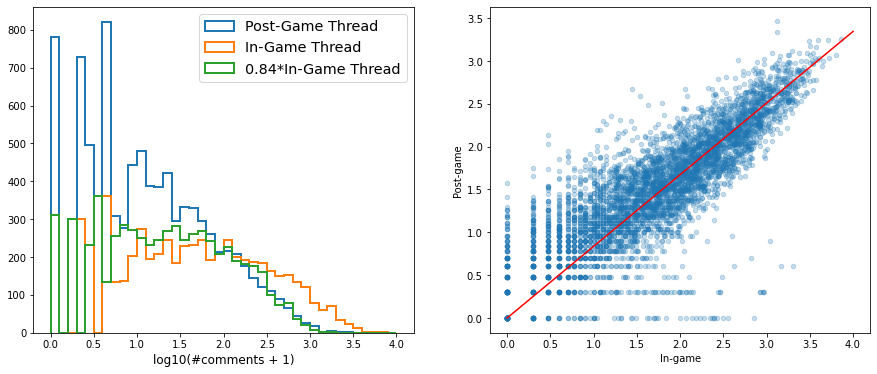

In [31]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(np.log10(tosave.loc[df.is_postgame].num_comments.values+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="Post-Game Thread")
axs[0].hist(np.log10(tosave.loc[~df.is_postgame].num_comments.values+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="In-Game Thread")
axs[0].hist(0.844*np.log10(tosave.loc[~df.is_postgame].num_comments.values+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="0.84*In-Game Thread")
axs[0].legend(fontsize='x-large')
axs[0].set_xlabel("log10(#comments + 1)", fontsize='large')

xs = []
ys = []
for gid in tosave.gid.unique():
    mask1 = (tosave.gid==gid) & ~tosave.is_postgame
    mask2 = (tosave.gid==gid) & tosave.is_postgame
    if mask1.sum()!=1 or mask2.sum()!=1:
        continue
    xs.append(tosave.num_comments[mask1].values[0])
    ys.append(tosave.num_comments[mask2].values[0])
xs = np.log10(np.array(xs)+1)
ys = np.log10(np.array(ys)+1)
axs[1].scatter(xs, ys, s=20, alpha=0.25)
# p = np.polyfit(xs, ys, deg=1)
a = np.sum(xs*ys)/np.sum(xs*xs)
p = [a,0]
print(p)
axs[1].plot([0,4],p[0]*np.array([0,4])+p[1],'r-')
axs[1].set_xlabel('In-game')
axs[1].set_ylabel('Post-game')